In [1]:
!pip install scikit-learn
!pip install scikit-image
!pip install scipy
!pip install pydicom
!pip install matplotlib
!pip install pandas
!pip install tensorflow==2.6.2
!pip install opencv-python==4.5.4.58

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom as dicom
import os
import cv2
import scipy.ndimage
import matplotlib.pyplot as plt
from skimage import measure, morphology, segmentation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage as ndimage

Ми встановлюємо змінну `INPUT_FOLDER` на шлях до каталогу `"../Dataset/lidc-data/DSB3/stage1"`. Також використовуємо метод os.listdir для отримання списку всіх файлів і каталогів у `INPUT_FOLDER`. Сортуємо список імен файлів за алфавітом за допомогою методу sort().
Друкуємо кількість елементів у списку пацієнтів за допомогою функції 
len.

In [4]:
# Some constants 
INPUT_FOLDER = '../Dataset/lidc-data/patients'
patients = os.listdir(INPUT_FOLDER)
patients.sort()
print(len(patients))
#patients.remove('.DS_Store')

1533


Створюємо функцію load_scan для завантаження серії зображень `DICOM` із папки, сортуємо їх за номером екземпляра та обчислюємо атрибут товщини фрагмента для кожного зображення.

In [5]:
# Load the scans in given folder path
def load_scan(path):
    ds = []
    for s in os.listdir(path):
        if( s != '.DS_Store'):
            ds.append(s)
    slices = [dicom.read_file((path + '/' + s),force = True) for s in ds]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

Ми створюємо функцію яка виконує перетворення піксельних значень зображень `DICOM` в одиниці Хаунсфілда, які є стандартизованою мірою, що використовується в КТ.

In [6]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

Ми завантажуємо КТ для конкретного пацієнта та візуалізуємо значення одиниць Хаунсфілда на КТ за допомогою гістограми та зрізу двовимірного зображення.

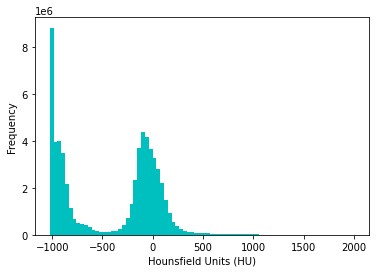

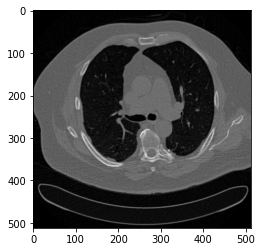

(0.0, 1.0, 0.0, 1.0)

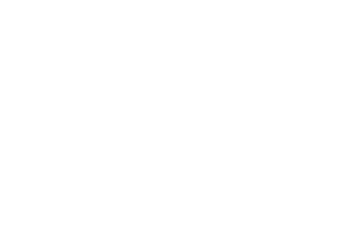

In [7]:
first_patient = load_scan(INPUT_FOLDER +'/'+ patients[2])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()
plt.axis('off')

# Алгоритм вододілу


Цей код ми використовуємо для завантаженя та попередньої обробки даних КТ пацієнта, потім робимо перетворення значення пікселей одиниці Хаунсфілда.

In [8]:
test_patient_scans = load_scan(INPUT_FOLDER +'/'+ patients[1])
test_patient_images = get_pixels_hu(test_patient_scans)

Ми відображаємо зображення яке є 100-м фрагментом з набору даних медичних зображень (який було попередньо завантажено та оброблено) у градаціях сірого.

Original Slice


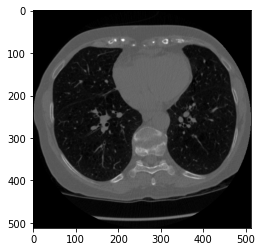

In [9]:
print ("Original Slice")
plt.imshow(test_patient_images[100], cmap='gray')
plt.show()

Ми використовує цей код який є частиною алгоритму сегментації легень, він використовує перетворення вододілу, щоб відокремити легені від навколишньої тканини на зображеннях КТ.

Внутрішній маркер


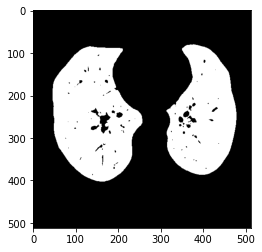

Зовнішній маркер


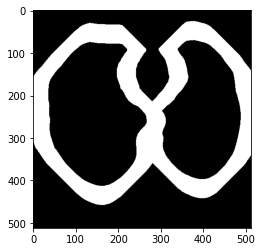

Маркер вододілу


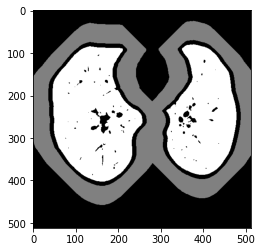

In [10]:
def generate_markers(image):
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    marker_internal = marker_internal_labels > 0
    #Creation of the external Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    #Creation of the Watershed Marker matrix
    marker_watershed = np.zeros((512, 512), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

#Show some example markers from the middle        
test_patient_internal, test_patient_external, test_patient_watershed = generate_markers(test_patient_images[100])
print ("Внутрішній маркер")
plt.imshow(test_patient_internal, cmap='gray')
plt.show()
print ("Зовнішній маркер")
plt.imshow(test_patient_external, cmap='gray')
plt.show()
print ("Маркер вододілу")
plt.imshow(test_patient_watershed, cmap='gray')
plt.show()

Ми отримуємо порівняння між вихідним зображенням і обробленим зображенням, створеним за допомогою алгоритму вододілу.

Ми створюємо функцію `separat_lungs`, яка приймає вхідне зображення та виконує різні методи обробки зображення, щоб відокремити легені від решти зображення. Ми повертаємо  сегментоване зображення легенів, зображення легеневих вузликів, зображення легеневого фільтра, контурне зображення, зображення вододілу, зображення градієнта Собела та зображення маркерів.

Легеневий вузлик


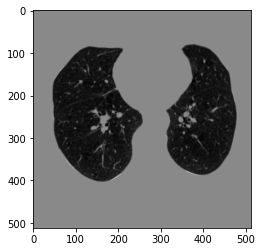

Градієнт Собеля


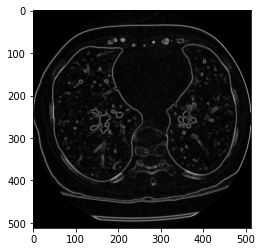

Зображення вододілу


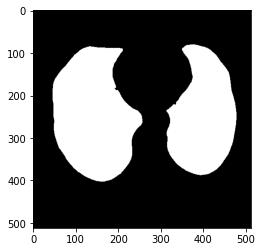

Схема після повторного включення


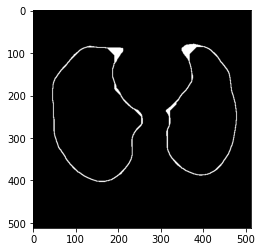

Легеневий фільтр після закриття


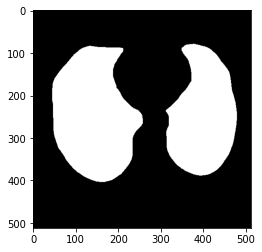

Сегментована легеня


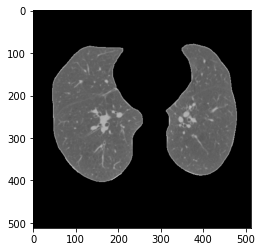

In [11]:
def seperate_lungs(image):
    #Creation of the markers as shown above:
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    #Creation of the Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    #Watershed algorithm
    watershed = segmentation.watershed(sobel_gradient, marker_watershed)
    
    #Reducing the image created by the Watershed algorithm to its outline
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)
    
    #Performing Black-Tophat Morphology for reinclusion
    #Creation of the disk-kernel and increasing its size a bit
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, 8)
    #Perform the Black-Hat
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    
    #Use the internal marker and the Outline that was just created to generate the lungfilter
    lungfilter = np.bitwise_or(marker_internal, outline)
    #Close holes in the lungfilter
    #fill_holes is not used here, since in some slices the heart would be reincluded by accident
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((7,7)), iterations=3)
    
    #Apply the lungfilter (note the filtered areas being assigned -2000 HU)
    segmented = np.where(lungfilter == 1, image, -2000*np.ones((512, 512)))

    #### nodule
    lung_nodule_1 = np.bitwise_or(marker_internal, image)
    lung_nodule = np.where(lungfilter == 1, lung_nodule_1, np.zeros((512, 512)))

    
    return segmented, lung_nodule, lungfilter, outline, watershed, sobel_gradient, marker_internal, marker_external, marker_watershed

#Some Testcode:
test_segmented, lung_nodule, test_lungfilter, test_outline, test_watershed, test_sobel_gradient, test_marker_internal, test_marker_external, test_marker_watershed = seperate_lungs(test_patient_images[100])

print ("Легеневий вузлик")
plt.imshow(lung_nodule, cmap='gray')
plt.show()
print ("Градієнт Собеля")
plt.imshow(test_sobel_gradient, cmap='gray')
plt.show()
print ("Зображення вододілу")
plt.imshow(test_watershed, cmap='gray')
plt.show()
print ("Схема після повторного включення")
plt.imshow(test_outline, cmap='gray')
plt.show()
print ("Легеневий фільтр після закриття")
plt.imshow(test_lungfilter, cmap='gray')
plt.show()
print ("Сегментована легеня")
plt.imshow(test_segmented, cmap='gray')
plt.show()

Ми отримуємо порівняння вхідного зображення з отриманим сегментованим зображенням легенів.

(-0.5, 511.5, 511.5, -0.5)

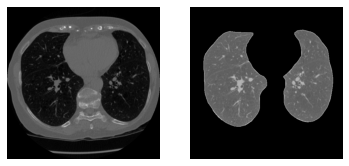

In [12]:
plt.subplot(121)
plt.imshow(test_patient_images[100],cmap = 'gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(test_segmented,cmap = 'gray')
plt.axis('off')

In [13]:
test_segmented.shape

(512, 512)

# Підготовка до класифікатора


In [14]:
labels_df = pd.read_csv('../Dataset/lidc-data/stage1_labels.csv', index_col=0)

labels_df.head()

,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1


In [15]:
for patient in patients[:1]:
    label = labels_df.at[(patient, 'cancer')]
    path = INPUT_FOLDER +'/'+ patient
    ds = []
    for s in os.listdir(path):
        if( s != '.DS_Store'):
            ds.append(s)
    slices = [dicom.read_file((path + '/' + s),force=True) for s in ds]
    #slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print(len(slices),label)
    print(slices[0])
    print(slices[0].PatientID)
    print('len of ds is ',len(ds))
    print(labels_df.at[(str(slices[0].PatientID), 'cancer')])


195 1
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.7009.9004.145029883272209688275539791662
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.31'
-------------------------------------------------
(0008, 0000) Group Length                        UL: 358
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.7009.9004.145029883272209688275539791662
(0008, 0060) Modality                            CS: 

In [18]:
#Встановити ліміт
limit = 4000;
# У нашій ситуації, фотографій багато, тому ми робимо ліміт,
# щоб нам вистачило ресурсів на конвертацію та зберігання даних

data = []
labels = []
print('*'*30)
print("data in converting.......")
print('*'*30)
j = 1

balancer = 0
for patient in patients:
    if len(labels) > limit:
        print("saving data")
        np.save("../Dataset/data/data_{}.npy".format(j) ,np.array(data))
        np.save("../Dataset/data/labels_{}.npy".format(j) ,np.array(labels))
        data = []
        labels = []
    test_patient_scans = load_scan(INPUT_FOLDER +'/'+ patients[j])
    test_patient_images = get_pixels_hu(test_patient_scans)
    path = INPUT_FOLDER +'/'+ patient
    ds = []
    for s in os.listdir(path):
        if( s != '.DS_Store'):
            ds.append(s)
    slices = [dicom.read_file((path + '/' + s),force=True) for s in ds]
    patient_label = labels_df.at[(str(slices[0].PatientID), 'cancer')]
    print("patient_number_{}".format(j))
    print("cancer -> {}".format(patient_label))
        
    if patient_label == 0:
        if balancer > 4:
            continue
        else:
            balancer += 1
    else:
        balancer -= 1

    i = 0
    for s in slices:
        try:
          i += 1
          if i in range(0,50):
            continue
          #taking 100 slices from each patient
          elif i in range(50, 150):
            img = test_patient_images[i]
            seg_img = seperate_lungs(img)[0]
            new_img = cv2.resize(seg_img, (224, 224))
            new_img = np.expand_dims(new_img,axis = -1)
            data.append(new_img)
            labels.append(patient_label)
        
            print("converted image is : "+str(len(labels)))
          else:
            break
        except IndexError:
          continue
    j += 1

print("Done")

******************************
data in converting.......
******************************
patient_number_1
cancer -> 1
converted image is : 1
converted image is : 2
converted image is : 3
converted image is : 4
converted image is : 5
converted image is : 6
converted image is : 7
converted image is : 8
converted image is : 9
converted image is : 10
converted image is : 11
converted image is : 12
converted image is : 13
converted image is : 14
converted image is : 15
converted image is : 16
converted image is : 17
converted image is : 18
converted image is : 19
converted image is : 20
converted image is : 21
converted image is : 22
converted image is : 23
converted image is : 24
converted image is : 25
converted image is : 26
converted image is : 27
converted image is : 28
converted image is : 29
converted image is : 30
converted image is : 31
converted image is : 32
converted image is : 33
converted image is : 34
converted image is : 35
converted image is : 36
converted image is : 37
conv

KeyboardInterrupt: 

In [19]:
print(len(data))
print(len(labels))

50
50


In [ ]:
data_new = np.array(data)
data_new.shape

(3069, 224, 224, 1)

In [ ]:
labels_new = np.array(labels)
labels_new.shape

(3069,)

In [ ]:
from numpy import save
print("saving data")
save("../Dataset/data/data_set.npy",data_new)
print("saving labels")
save("../Dataset/data/labels_set.npy",labels_new)

saving data
saving labels


: 